<a href="https://colab.research.google.com/github/Camicb/practice-classification/blob/main/Bank_Marketing_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Bank Marketing (with social/economic context)**

#1. Introduction

The present dataset is based on "Bank Marketing" UCI dataset (please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

   The data is enriched by the addition of five new social and economic features/attributes (national wide indicators from a ~10M population country), published by the Banco de Portugal and publicly available at: https://www.bportugal.pt/estatisticasweb.

 This dataset is publicly available for research. The details are described in: [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. *A Data-Driven Approach to Predict the Success of Bank Telemarketing*. Decision Support Systems, In press, http://dx.doi.org/10.1016/j.dss.2014.03.001. 
 
 Available at: 

[pdf] http://dx.doi.org/10.1016/j.dss.2014.03.001

[bib] http://www3.dsi.uminho.pt/pcortez/bib/2014-dss.txt

**OBJECTIVE:** The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit. 



#2. Import Required Libraries

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip -q
!pip install lightgbm -q
!git clone --recursive https://github.com/dmlc/xgboost -v
!pip install scikit-plot -q
!pip install -U imbalanced-learn -q
!jupyter nbextension enable --py widgetsnbextension -v
!pip install delayed -q

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
from pandas_profiling import ProfileReport
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE


Colab mode enabled.


In [3]:
np.random.seed(2021) # A seed for reproducibility

#3. Exploratory Data Analysis
##3.1 About the data

INPUT VARIABLES:


   1 - **age** (numeric)

   2 - **job** : type of job (categorical: "admin.", "blue-collar",  "entrepreneur", "housemaid", "management", "retired", "self-employed", "services", "student", "technician", "unemployed", "unknown")

   3 - **marital** : marital status (categorical: "divorced", "married", "single", "unknown";  note: "divorced" means divorced or widowed)

   4 - **education** (categorical: "basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown")

   5 - **default**: has credit in default? (categorical: "no", "yes", "unknown")

   6 - **housing**: has housing loan? (categorical: "no", "yes", "unknown")

   7 - **loan**: has personal loan? (categorical: "no", "yes", "unknown")

   8 - **contact**: contact communication type (categorical: "cellular", "telephone") 

   9 - **month**: last contact month of year (categorical: "jan",  "feb",  "mar",  ...,  "nov",  "dec")

  10 - **day_of_week**: last contact day of the week (categorical: "mon", "tue", "wed", "thu", "fri")

  11 - **duration**: last contact duration, in seconds (numeric). **Important note**:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

  12 - **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)

  13 - **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

  14 - **previous**: number of contacts performed before this campaign and for this client (numeric)

  15 - **poutcome**: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
 
   16 - **emp.var.rate**: employment variation rate - quarterly indicator (numeric)

  17 - **cons.price.idx**: consumer price index - monthly indicator (numeric)     

  18 - **cons.conf.idx**: consumer confidence index - monthly indicator (numeric)     

  19 - **euribor3m**: euribor 3 month rate - daily indicator (numeric)

  20 - **nr.employed**: number of employees - quarterly indicator (numeric)


OUTPUT VARIABLE (DESIRED TARGET):

  21 - **subscribed** - has the client subscribed a term deposit? (binary: "yes","no")

NOTE: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 

In [4]:
# Loading the data
bank = pd.read_excel('/content/drive/MyDrive/DATASETS/bank-additional/bank-additional-full.xlsx', na_values='unknown')

## 3.2 Exploratory data analysis

In [5]:
bank.info()
bank.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

age        job  marital  ... euribor3m nr.employed subscribed
0   56  housemaid  married  ...     4.857      5191.0         no
1   57   services  married  ...     4.857      5191.0         no
2   37   services  married  ...     4.857      5191.0         no
3   40     admin.  married  ...     4.857      5191.0         no
4   56   services  married  ...     4.857      5191.0         no

[5 rows x 21 columns]

In [6]:
# Statistical report
profile = ProfileReport(bank, html={'style': {'full_width': True, 'primary_color': '#30b6c2'}},  samples=None, missing_diagrams=None, interactions=None)
profile.to_file("report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

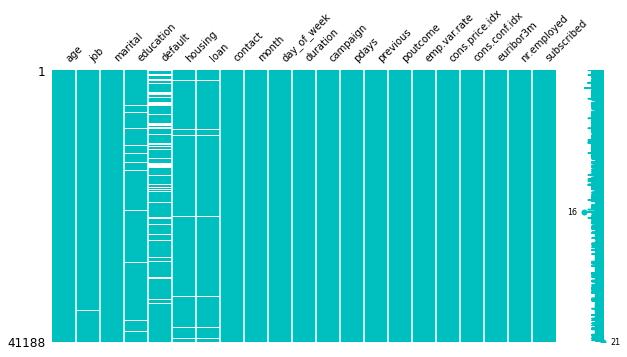

In [7]:
# Visualization of missing values
msno.matrix(bank, figsize=(10,5), fontsize=10, color=(0.0, 0.75, 0.75))

# 4. Preprocessing
i will fix some issues concerning to the data types and then I will split the data twice, in order to have a training, validation and a test datasets.

In [8]:
# Fixing data types 
bank['default'] = bank['default'].astype('category')
bank['loan'] = bank['loan'].astype('category')
bank['housing'] = bank['housing'].astype('category')
bank['subscribed'] = bank['subscribed'].astype('category')

# Filling missing values
bank['default'].replace({np.nan: 'unknown'}, inplace=True)
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             40858 non-null  object  
 2   marital         41108 non-null  object  
 3   education       39457 non-null  object  
 4   default         41188 non-null  object  
 5   housing         40198 non-null  category
 6   loan            40198 non-null  category
 7   contact         41188 non-null  object  
 8   month           41188 non-null  object  
 9   day_of_week     41188 non-null  object  
 10  duration        41188 non-null  int64   
 11  campaign        41188 non-null  int64   
 12  pdays           41188 non-null  int64   
 13  previous        41188 non-null  int64   
 14  poutcome        41188 non-null  object  
 15  emp.var.rate    41188 non-null  float64 
 16  cons.price.idx  41188 non-null  float64 
 17  cons.conf.id

In [9]:
# Spliting data into training, validation and test datasets

X = bank.drop(['subscribed', 'duration'], axis=1)
y = bank['subscribed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(26360, 19) (26360,)
(8238, 19) (8238,)
(6590, 19) (6590,)


# 5. Modeling
 I will use sklearn pipelines for preprocessing and modeling.

In [11]:
# Selecting numerical and categorical variables
num_var = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
           'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

cat_var = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week','poutcome']

# Pre-processing variables
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', MinMaxScaler())])
categorical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy = 'most_frequent')), ('encoder', OneHotEncoder())])

# Joining variables
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_var), ('cat', categorical_transformer, cat_var)])

# Choosing classifier 
classifiers = [
    RandomForestClassifier(),
    xgb.XGBClassifier(),
    lgb.LGBMClassifier(objective='binary', n_jobs=-1)
    ]
#dim = PCA()
#('dimensionality', dim)---don't improve perfomance

# Joining everything
for classifier in classifiers:
  pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_val)
  print(classifier)
  print(' ')
  print("Weighted F1 score on test set: "
          "%0.3f" % f1_score(y_val, y_pred, average='weighted'))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple

RandomForestClassifier()
 
Weighted F1 score on test set: 0.877


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple

XGBClassifier()
 
Weighted F1 score on test set: 0.879


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple

LGBMClassifier(objective='binary')
 
Weighted F1 score on test set: 0.885


I will choose the LightGBM classifier for modeling althought the 3 options have slightly similar results. 

In [12]:
# Chosen model
cf = lgb.LGBMClassifier(objective='binary', n_jobs=-1, learning_rate=0.1, reg_alpha=0.5)
model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', cf)])
model.fit(X_train, y_train) 
y_pred = model.predict(X_val)
print(' ')
print("Weighted F1 score on test set: " 
          "%0.3f" % f1_score(y_val, y_pred, average='weighted'))


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple

 
Weighted F1 score on test set: 0.885


### 5.1 Understanding the model

In [13]:
# Classification report
target_names=['no','yes']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          no       0.92      0.98      0.95      5848
         yes       0.64      0.29      0.40       742

    accuracy                           0.90      6590
   macro avg       0.78      0.63      0.67      6590
weighted avg       0.88      0.90      0.88      6590



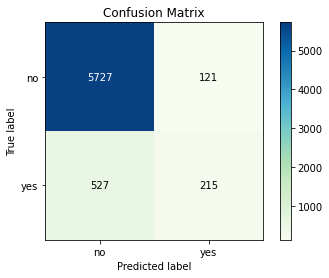

In [14]:
# Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_val, y_pred, cmap='GnBu')

In [15]:
# Confusion Matrix percentages
confusion_matrix(y_val, y_pred, normalize='all')

array([[0.86904401, 0.01836115],
       [0.07996965, 0.03262519]])

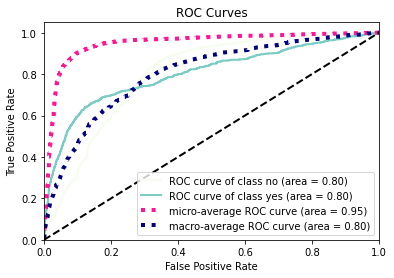

In [16]:
# ROC - AUC Curves
y_probas = model.predict_proba(X_val)
skplt.metrics.plot_roc(y_val, y_probas, cmap='GnBu')
plt.show()

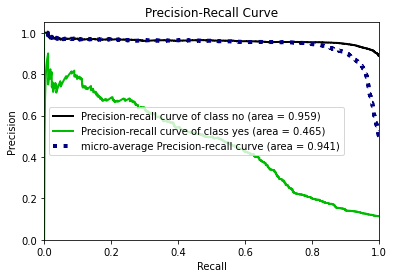

In [17]:
# Precision - recall curve
skplt.metrics.plot_precision_recall(y_val, y_probas)

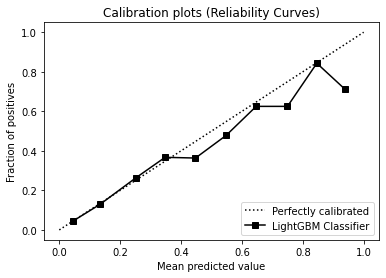

In [18]:
# Calibration Curve
model_probas = model.fit(X_train, y_train).predict_proba(X_val)
probas_list = [model_probas]
clf_name = ['LightGBM Classifier']
skplt.metrics.plot_calibration_curve(y_val, probas_list, clf_name)

## 5.2 Adjusting the model

According to the metrics and visualizations, there are an important number of clients that subscribed to a deposit but the model predicted the opposite. In practice, this could lead to the exclusion of a significant number of potential customers. In order to improve the situation, I will oversample the data to manage the imbalance of attributes in the target variable, and adjust some hyperparameter of the classifier.

In [19]:
# Obtaining the training and validation data transformed by the preprocessing pipeline as DataFrames
onehot_columns = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names(input_features=cat_var)

X_values_train = preprocessor.fit_transform(X_train)
df_from_array_pipeline_train = pd.DataFrame(X_values_train, columns = num_var + list(onehot_columns))

X_values_val = preprocessor.fit_transform(X_val)
df_from_array_pipeline_val = pd.DataFrame(X_values_val, columns = num_var + list(onehot_columns))

In [20]:
# Oversampling with SMOTE
X_resampled, y_resampled = SMOTE(sampling_strategy=0.3).fit_resample(df_from_array_pipeline_train, y_train)
y_resampled.value_counts()

no     23390
yes     7017
Name: subscribed, dtype: int64

In [21]:
# Adjusting some hyperparameters
cf2 = lgb.LGBMClassifier(objective='binary', n_jobs=-1, learning_rate=0.5, reg_alpha=0.5, is_unbalance=True)
cf2.fit(X_resampled, y_resampled)
y_pred_resampled = cf2.predict(df_from_array_pipeline_val)
print(' ')
print("Weighted recall score on test set: " 
          "%0.3f" % recall_score(y_val, y_pred_resampled, average='weighted'))

LGBMClassifier(is_unbalance=True, learning_rate=0.5, objective='binary',
               reg_alpha=0.5)

 
Weighted recall score on test set: 0.548


In [22]:
# Classification report
target_names=['no','yes']
print(classification_report(y_val, y_pred_resampled, target_names=target_names))

              precision    recall  f1-score   support

          no       0.94      0.52      0.67      5848
         yes       0.16      0.74      0.27       742

    accuracy                           0.55      6590
   macro avg       0.55      0.63      0.47      6590
weighted avg       0.85      0.55      0.63      6590



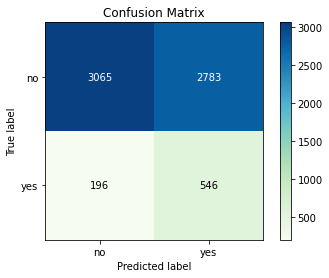

In [23]:
# Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_val, y_pred_resampled, cmap='GnBu')

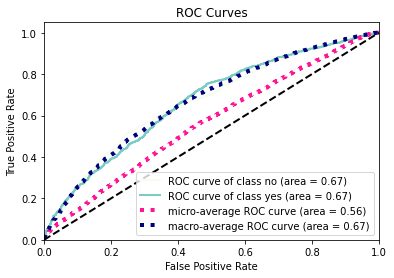

In [24]:
# ROC - AUC Curves
y_probas = cf2.predict_proba(df_from_array_pipeline_val)
skplt.metrics.plot_roc(y_val, y_probas, cmap='GnBu')
plt.show()

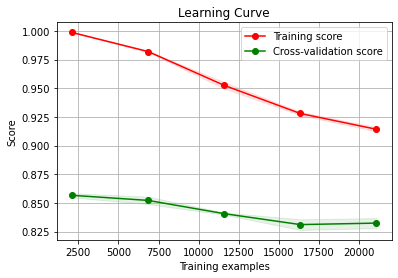

In [25]:
skplt.estimators.plot_learning_curve(cf2, df_from_array_pipeline_train, y_train)

Learning curve shows that more data could be very useful to improve model

# 6. Predictions

Predictions will be performed using the second model, but the first one is still available for use and improvement. If the contact with clients is through person to person calls, the first model is suggested. If the calls are automated or the contact is through emails, the second model is better.

In [26]:
# Final model
model_2 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', cf2)])

# Predictions in test data
y_pred_2 = model_2.predict(X_test)
print(' ')
print("Weighted F1 score on test set: " 
          "%0.3f" % f1_score(y_test, y_pred_2, average='weighted'))

 
Weighted F1 score on test set: 0.618


In [27]:
# Classification report
target_names=['no','yes']
print(classification_report(y_test, y_pred_2, target_names=target_names))

              precision    recall  f1-score   support

          no       0.94      0.51      0.66      7310
         yes       0.16      0.73      0.26       928

    accuracy                           0.54      8238
   macro avg       0.55      0.62      0.46      8238
weighted avg       0.85      0.54      0.62      8238



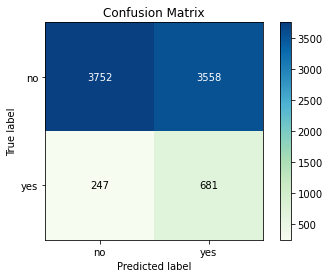

In [28]:
# Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_2, cmap='GnBu')

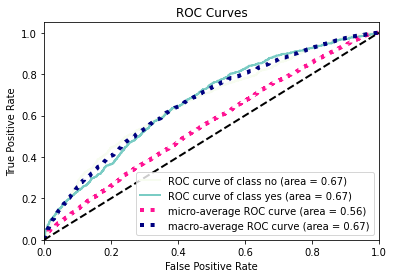

In [29]:
# ROC - AUC Curves
y_probas = model_2.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas, cmap='GnBu')
plt.show()

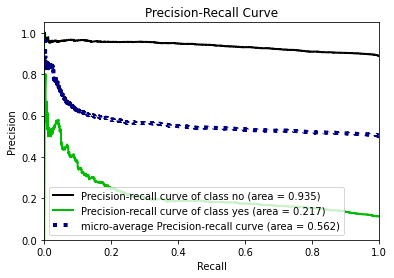

In [30]:
# Precision - recall curve
skplt.metrics.plot_precision_recall(y_test, y_probas)

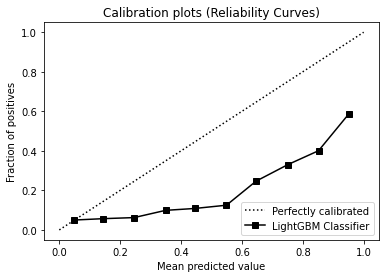

In [31]:
# Calibration Curve
model_probas = model_2.fit(X_train, y_train).predict_proba(X_test)
probas_list = [model_probas]
clf_name = ['LightGBM Classifier']
skplt.metrics.plot_calibration_curve(y_test, probas_list, clf_name)

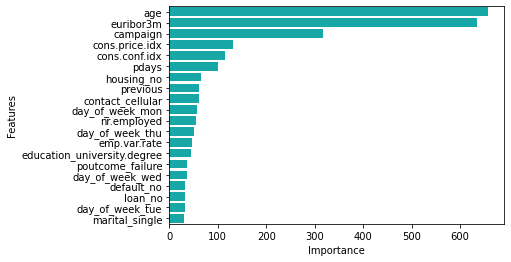

In [32]:
# Feature importance
ft = {'Features':num_var + list(onehot_columns), 'Importance': np.array(model.named_steps['classifier'].feature_importances_)}
feature_importance = pd.DataFrame(ft).sort_values(by=['Importance'], ascending=False)
sns.barplot(x='Importance', y='Features', data=feature_importance[0:20], label='Importance', color='c')
